# Importing Libraries

In [62]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Creating synthetic dataset

In [63]:
import random

def add_missing_quote(tag_type, attribute, value, content):
    return f"<{tag_type} {attribute}={value}>{content}</{tag_type}>", f"<{tag_type} {attribute}='{value}'>{content}</{tag_type}>"

def missing_closing_tag(tag_type, content):
    return f"<{tag_type}>{content}", f"<{tag_type}>{content}</{tag_type}>"

def add_missing_alt(img_src):
    return f"<img src='{img_src}'>", f"<img src='{img_src}' alt=''>"

def misnested_tags(outer_tag, inner_tag, content):
    return f"<{outer_tag}><{inner_tag}>{content}</{outer_tag}></{inner_tag}>", f"<{inner_tag}><{outer_tag}>{content}</{outer_tag}></{inner_tag}>"

tags = ["div", "p", "a", "span", "h1", "h2", "h3", "ul", "li", "table", "tr", "td"]
attributes = ["href", "id", "class", "style", "src", "alt"]
values = ["link.html", "container", "header", "width:100px", "image.jpg", "description"]
contents = ["Hello", "Title", "Link", "Text", "List Item", "Data", "Content"]

dataset = []

for _ in range(2000):
    tag = random.choice(tags)
    attribute = random.choice(attributes)
    value = random.choice(values)
    content = random.choice(contents)
    dataset.append(add_missing_quote(tag, attribute, value, content))

for _ in range(2000):
    tag = random.choice(tags)
    content = random.choice(contents)
    dataset.append(missing_closing_tag(tag, content))

for _ in range(2000):
    img_src = random.choice(values)
    dataset.append(add_missing_alt(img_src))

for _ in range(2000):
    outer_tag = random.choice(tags)
    inner_tag = random.choice(tags)
    content = random.choice(contents)
    if outer_tag != inner_tag:
        dataset.append(misnested_tags(outer_tag, inner_tag, content))

for _ in range(8000):
    tag = random.choice(tags)
    attribute = random.choice(attributes)
    value = random.choice(values)
    content = random.choice(contents)
    dataset.append((f"<{tag} {attribute}='{value}'>{content}", f"<{tag} {attribute}='{value}'>{content}</{tag}>"))

random.shuffle(dataset)
bad_practices = [i[0] for i in dataset ]
good_practices = [i[1] for i in dataset]

# # Calling DataFrame after zipping both lists, with columns specified
df = pd.DataFrame(list(zip(bad_practices, good_practices)), columns =['Bad_Practices','Good_Practices'])
newdf = df.drop_duplicates()

# Saving Dataset

In [64]:
newdf.to_csv('Html_Code_Correction_Dataset.csv',index=False)

# Loading Dataset

In [65]:
df = pd.read_csv('/content/Html_Code_Correction_Dataset.csv')
bad_practices = df['Bad_Practices']
good_practices = df['Good_Practices']

In [66]:
len(df)

5157

# Tokenizing Text Sequences

In [67]:
# Step 3: Train an ML model based on the above

# Tokenize the data
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>')
tokenizer.fit_on_texts(bad_practices + good_practices)

# Convert texts to sequences and pad them for consistent length
X_bad = tokenizer.texts_to_sequences(bad_practices)
X_good = tokenizer.texts_to_sequences(good_practices)
X = pad_sequences(X_bad + X_good, padding='post')

# Label bad as 0 and good as 1
y_bad = [0] * len(X_bad)
y_good = [1] * len(X_good)
y = np.array(y_bad + y_good)

# Splitting Dataset

In [68]:
from sklearn.model_selection import train_test_split
# Split the dataset into training+validation and testing sets (80% training+validation, 20% testing)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training+validation set into separate training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Creating Model

In [69]:
# Create a simple neural network
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=16, input_length=X.shape[1]),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1, activation='sigmoid')
])



# Plotting Model

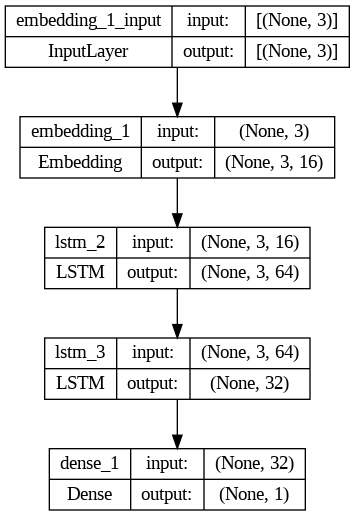

In [70]:
# summarize the model
plot_model(model, 'model.png', show_shapes=True)

# Training Model

In [71]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, verbose=2)

Epoch 1/20
207/207 - 10s - loss: 0.4167 - accuracy: 0.8276 - val_loss: 0.2030 - val_accuracy: 0.8964 - 10s/epoch - 47ms/step
Epoch 2/20
207/207 - 2s - loss: 0.1402 - accuracy: 0.9159 - val_loss: 0.1852 - val_accuracy: 0.9104 - 2s/epoch - 9ms/step
Epoch 3/20
207/207 - 2s - loss: 0.1133 - accuracy: 0.9188 - val_loss: 0.2119 - val_accuracy: 0.9073 - 2s/epoch - 8ms/step
Epoch 4/20
207/207 - 2s - loss: 0.1090 - accuracy: 0.9233 - val_loss: 0.2256 - val_accuracy: 0.8995 - 2s/epoch - 8ms/step
Epoch 5/20
207/207 - 2s - loss: 0.1064 - accuracy: 0.9236 - val_loss: 0.2406 - val_accuracy: 0.9061 - 2s/epoch - 8ms/step
Epoch 6/20
207/207 - 2s - loss: 0.1054 - accuracy: 0.9255 - val_loss: 0.2543 - val_accuracy: 0.9049 - 2s/epoch - 8ms/step
Epoch 7/20
207/207 - 2s - loss: 0.1039 - accuracy: 0.9235 - val_loss: 0.2670 - val_accuracy: 0.9055 - 2s/epoch - 10ms/step
Epoch 8/20
207/207 - 2s - loss: 0.1031 - accuracy: 0.9273 - val_loss: 0.2693 - val_accuracy: 0.9049 - 2s/epoch - 10ms/step
Epoch 9/20
207/207 

# Plotting Accuracy and Loss

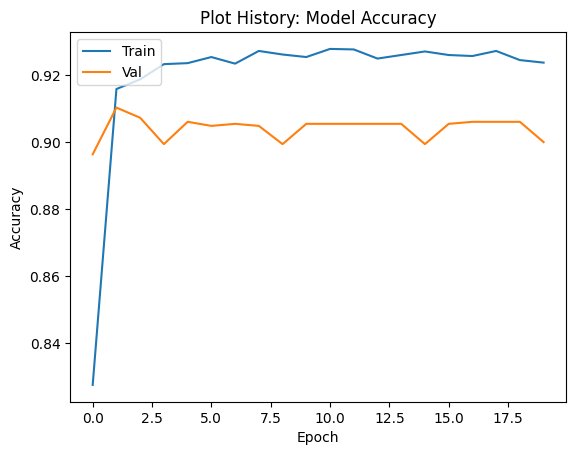

In [72]:
# plot the accuracy and loss
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Plot History: Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

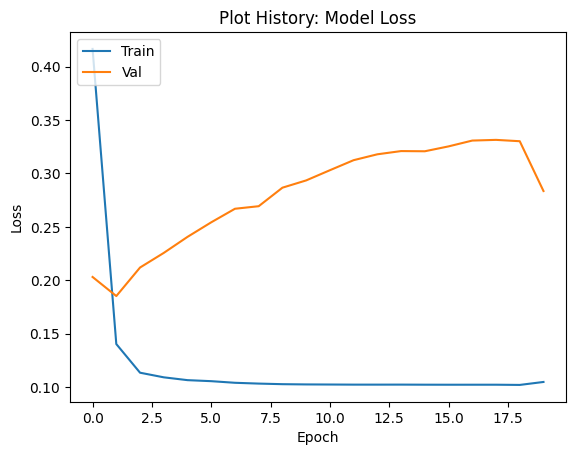

In [73]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.title('Plot History: Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Evaluating Model On Testset

In [74]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

65/65 [==============================] - 0s 3ms/step - loss: 0.2485 - accuracy: 0.9045
Test Loss: 0.2485141158103943
Test Accuracy: 0.9045079946517944


# Checking Results

In [75]:
def rectify_html(html_code):
    # For simplicity, we use a rule-based approach to fix the bad practices
    rectifications = {
        "<p>This is bad": "<p>This is good</p>",
        "<center>Centered content": "<div style='text-align: center;'>Centered content</div>",
        "<div style='color: red'>": "<div><span style='color: red'>Red text</span></div>",
        "<table><tr><td>Layout</td></tr></table>": "<div>Layout with CSS</div>",
        "<img src='image.jpg'>": "<img src='image.jpg' alt='Image description'>",
        "This is content": "<div>This is content</div>",
        "<div custom-attr='value'>": "<div data-custom-attr='value'>",
        "<div id='duplicateID'>": "<div id='uniqueID'>",
        "<img src='http://insecure.com/image.jpg'>": "<img src='https://secure.com/image.jpg'>",
        "<div>This is div</div>": "<section>This is section</section>"
    }
    # Replace any matching bad practice in the provided code
    for bad, good in rectifications.items():
        html_code = html_code.replace(bad, good)
    return html_code

In [76]:
# Step 4: Predict And Rectify sample HTML code

def predict_and_rectify(html_code):
    # Convert the html_code to a sequence and pad it
    sequence = tokenizer.texts_to_sequences([html_code])
    padded_sequence = pad_sequences(sequence, maxlen=X.shape[1], padding='post')

    # Predict
    prediction = model.predict(padded_sequence)

    # If it's bad practice (prediction close to 0), rectify it
    if prediction[0][0] < 0.5:
        corrected_html = rectify_html(html_code)
        return "Bad Practice. Rectified Code:", corrected_html
    else:
        return "Good Practice."

# Test with a sample
sample_code = "<img src='http://insecure.com/image.jpg'>"
result = predict_and_rectify(sample_code)
print("Original:", sample_code)
print(result)


1/1 [==============================] - 1s 1s/step
Original: <img src='http://insecure.com/image.jpg'>
('Bad Practice. Rectified Code:', "<img src='https://secure.com/image.jpg'>")


# Saving Model

In [77]:
model.save("html_correction_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [78]:
import pickle

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Later, load it back
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)